# Global Sequence MIP Formulation (M1* formulation in paper)

## Model Declaration and Data Input (Example 1)

In [1]:
from pyomo import environ as pe
from math import ceil
from matplotlib import pyplot as plt
model = pe.ConcreteModel(name='Global Sequence MIP Formulation')

In [2]:
data_object = None
try:
    data_object  = open('Example1.dat', 'w')
    data_object.write('''
    
table I={I} q(I) r(I) d(I):
      I     q    r    d   :=
      A     30   0    .
      B     40   0    .
      C     40   0    .;

set K := K1 K2;

table J={J}  Jk={J,K}  b_min(J)  b_max(J):
      J      K         b_min     b_max   :=
      J1     K1        10        30
      J2     K1        20        40
      J3     K2        20        35
      J4     K2        25        50;

set JF := ;
set FP := ;
      
param tau_F :     J1     J2   J3                      J4 :=
            A     2.5    2    0.888888888888888889    2
            B     2.5    2    0.888888888888888889    2
            C     2.5    2    0.888888888888888889    2;

param tau_P :     J1                    J2   J3                       J4 :=
            A     0.08333333333333333   0.1  0.08888888888888888889   0.08
            B     0.08333333333333333   0.1  0.08888888888888888889   0.08
            C     0.08333333333333333   0.1  0.08888888888888888889   0.08;

table H := 30;

''')
finally:
    data_object.close()
    
data = pe.DataPortal()
data.load(filename="Example1.dat", model=model)

## Set Declaration

In [3]:
model.I = pe.Set(initialize=data['I'],ordered=True)
model.J = pe.Set(initialize=data['J'],ordered=True)
model.K = pe.Set(initialize=data['K'],ordered=True)
model.Jk = pe.Set(within=model.J*model.K,initialize=data['Jk'])
model.JF = pe.Set(within=model.I*model.J,initialize=data['JF'])
model.FP = pe.Set(within=model.J*model.J,initialize=data['FP'])

## Special Set: $JA_{ik}$

In [4]:
def JAik_rule(model):
    tmp=[]
    for j in model.J:
        for i in model.I:
            for k in model.K:
                if ((j,k) in model.Jk) and ((i,j) not in model.JF):
                    tmp.append((j,i,k))
    return tmp
model.JAik = pe.Set(within=model.J*model.I*model.K,initialize=JAik_rule)

In [5]:
model.JAik.pprint()

JAik : Dim=0, Dimen=3, Size=12, Domain=JAik_domain, Ordered=False, Bounds=None
    [('J1', 'A', 'K1'), ('J1', 'B', 'K1'), ('J1', 'C', 'K1'), ('J2', 'A', 'K1'), ('J2', 'B', 'K1'), ('J2', 'C', 'K1'), ('J3', 'A', 'K2'), ('J3', 'B', 'K2'), ('J3', 'C', 'K2'), ('J4', 'A', 'K2'), ('J4', 'B', 'K2'), ('J4', 'C', 'K2')]


## Parameters Declaration

In [6]:
model.H = pe.Param(initialize=data['H'])
model.q = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['q'])
model.r = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['r'],default=0)
model.d = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['d'],default=model.H)
model.b_min = pe.Param(model.J,within=pe.NonNegativeReals,initialize=data['b_min'])
model.b_max = pe.Param(model.J,within=pe.NonNegativeReals,initialize=data['b_max'])
model.tau_F = pe.Param(model.I,model.J,within=pe.NonNegativeReals,initialize=data['tau_F'])
model.tau_P = pe.Param(model.I,model.J,within=pe.NonNegativeReals,initialize=data['tau_P'])

## Special Set: $L_i$

* (1)
* (2)

In [7]:
# First, we need to compute for each i, what is the minimum batch size across all stages
def bi_min_rule(model,i):
    return max(min(model.b_min[j] for j in model.J if (j,i,k) in model.JAik) for k in model.K)
model.bi_min = pe.Param(model.I,initialize=bi_min_rule)

def bi_max_rule(model,i):
    return min(max(model.b_max[j] for j in model.J if (j,i,k) in model.JAik) for k in model.K)
model.bi_max = pe.Param(model.I,initialize=bi_max_rule)

# Second, we can use demand data, compute upper and lower bound for the number of batches
def li_max_rule(model,i):
    return ceil(model.q[i]/model.bi_min[i])
model.li_max = pe.Param(model.I,initialize=li_max_rule)

def li_min_rule(model,i):
    return ceil(model.q[i]/model.bi_max[i])
model.li_min = pe.Param(model.I,initialize=li_min_rule)

# Third, construct the L(i) list
def Li_rule(model):
    tmp=[]
    for i in model.I:
        for l in range(1,model.li_max[i]+1):
            tmp.append((i,l))
    return tmp
model.Li = pe.Set(dimen=2,initialize=Li_rule,ordered=True)

In [8]:
model.Li.pprint()

Li : Dim=0, Dimen=2, Size=6, Domain=None, Ordered=Insertion, Bounds=None
    [('A', 1), ('A', 2), ('B', 1), ('B', 2), ('C', 1), ('C', 2)]


## Batching and Assignment Variables Declaration

In [9]:
model.B = pe.Var(model.Li,within=pe.NonNegativeReals)
model.B_ = pe.Var(model.Li,model.J,within=pe.NonNegativeReals)
model.Z = pe.Var(model.Li,within=pe.Binary)
model.X = pe.Var(model.Li,model.J,within=pe.Binary)

## Batching and Assignment Constraints

* (3)

In [10]:
def demand_rule(model,i):
    return sum(model.B[i_,l] for i_,l in model.Li if i_ == i) >= model.q[i]
model.demand_con = pe.Constraint(model.I,rule=demand_rule)

* (4) According to paper, becomes obsolete with constraint 5-7

In [11]:
def batch_select_rule1(model,i,l):
    return model.B[i,l] <= model.bi_max[i]*model.Z[i,l]
model.batch_select_con1 = pe.Constraint(model.Li,rule=batch_select_rule1)

def batch_select_rule2(model,i,l):
    return model.bi_min[i]*model.Z[i,l] <= model.B[i,l]
model.batch_select_con2 = pe.Constraint(model.Li,rule=batch_select_rule2)

* (5)

In [12]:
def unit_select_rule(model,i,l,k):
    return model.Z[i,l] == sum(model.X[i,l,j] for j in model.J if (j,i,k) in model.JAik)
model.unit_select_con = pe.Constraint(model.Li,model.K,rule=unit_select_rule)

* (6)

In [13]:
def unit_size_rule(model,i,l,k):
    return model.B[i,l] == sum(model.B_[i,l,j] for j in model.J if (j,i,k) in model.JAik)
model.unit_size_con = pe.Constraint(model.Li,model.K,rule=unit_size_rule)

* (7)

In [14]:
def unit_bound_rule1(model,i,l,j):
    return model.B_[i,l,j] <= model.b_max[j]*model.X[i,l,j]
model.unit_bound_con1 = pe.Constraint(model.Li,model.J,rule=unit_bound_rule1)

def unit_bound_rule2(model,i,l,j):
    return model.b_min[j]*model.X[i,l,j] <= model.B_[i,l,j]
model.unit_bound_con2 = pe.Constraint(model.Li,model.J,rule=unit_bound_rule2)

* (8)

In [15]:
def batch_order_rule(model,i,l):
    if l == ceil(model.q[i]/model.bi_min[i]): return pe.Constraint.Skip
    return model.Z[i,l+1] <= model.Z[i,l]
model.batch_order_con = pe.Constraint(model.Li,rule=batch_order_rule)

## Special Set: $IL$

In [16]:
def IL_rule(model):
    tmp=[]
    for i,l in model.Li:
        for i_,l_ in model.Li:
            if (i != i_) or (i == i_ and l != l_ ):
                tmp.append((i,l,i_,l_))
    return tmp
model.IL = pe.Set(dimen=4,initialize=IL_rule,ordered=True)

In [17]:
model.IL.pprint()

IL : Dim=0, Dimen=4, Size=30, Domain=None, Ordered=Insertion, Bounds=None
    [('A', 1, 'A', 2), ('A', 1, 'B', 1), ('A', 1, 'B', 2), ('A', 1, 'C', 1), ('A', 1, 'C', 2), ('A', 2, 'A', 1), ('A', 2, 'B', 1), ('A', 2, 'B', 2), ('A', 2, 'C', 1), ('A', 2, 'C', 2), ('B', 1, 'A', 1), ('B', 1, 'A', 2), ('B', 1, 'B', 2), ('B', 1, 'C', 1), ('B', 1, 'C', 2), ('B', 2, 'A', 1), ('B', 2, 'A', 2), ('B', 2, 'B', 1), ('B', 2, 'C', 1), ('B', 2, 'C', 2), ('C', 1, 'A', 1), ('C', 1, 'A', 2), ('C', 1, 'B', 1), ('C', 1, 'B', 2), ('C', 1, 'C', 2), ('C', 2, 'A', 1), ('C', 2, 'A', 2), ('C', 2, 'B', 1), ('C', 2, 'B', 2), ('C', 2, 'C', 1)]


## Sequencing and Timing Variables Declaration

In [18]:
model.Y = pe.Var(model.IL,model.K,within=pe.Binary)
model.T = pe.Var(model.Li,model.K,within=pe.NonNegativeReals)
model.LT = pe.Var(model.Li,within=pe.NonNegativeReals)

## Sequencing and Timing Constraints

* (9)

In [19]:
def same_unit_rule(model,i,l,i_,l_,k,j):
    if (model.I.ord(i) <= model.I.ord(i_)) and ((j,i,k) in model.JAik) and ((j,i_,k) in model.JAik):
        return model.X[i,l,j] + model.X[i_,l_,j] - 1 <= model.Y[i,l,i_,l_,k] + model.Y[i_,l_,i,l,k]
    else:
        return pe.Constraint.Skip
model.same_unit_con = pe.Constraint(model.IL,model.K,model.J,rule=same_unit_rule)

* (10)

In [20]:
def finish_time_rule(model,i,l,i_,l_,k):
    return model.T[i_,l_,k] >= model.T[i,l,k] - model.H*(1-model.Y[i,l,i_,l_,k]) + sum( (model.tau_F[i_,j] \
            *model.X[i_,l_,j] + model.tau_P[i_,j]*model.B_[i_,l_,j]) for j in model.J if (j,i_,k) in model.JAik)
model.finish_time_con = pe.Constraint(model.IL,model.K,rule=finish_time_rule)

* (11)

In [21]:
def between_stages_rule(model,i,l,k):
    if model.K.ord(k) == len(model.K): return pe.Constraint.Skip
    return model.T[i,l,model.K.next(k)] >= model.T[i,l,k] + sum((model.tau_F[i,j]*model.X[i,l,j] \
             + model.tau_P[i,j]*model.B_[i,l,j]) for j in model.J if (j,i,model.K.next(k)) in model.JAik)
model.between_stages_con = pe.Constraint(model.Li,model.K,rule=between_stages_rule)

## Additional Constraints

* (12) (13)

In [22]:
def start_rule(model,i,l,k):
    return model.T[i,l,k] >= model.r[i]*model.Z[i,l] + sum( (model.tau_F[i,j]*model.X[i,l,j] \
             + model.tau_P[i,j]*model.B_[i,l,j]) for k_ in model.K if model.K.ord(k_) <= model.K.ord(k) \
                                                           for j in model.J if (j,i,k_) in model.JAik )
model.start_con = pe.Constraint(model.Li,model.K,rule=start_rule)

def end_rule(model,i,l,k):
    return model.T[i,l,k] <= model.d[i]*model.Z[i,l] - sum( (model.tau_F[i,j]*model.X[i,l,j] \
             + model.tau_P[i,j]*model.B_[i,l,j]) for k_ in model.K if model.K.ord(k_) > model.K.ord(k) \
                                                           for j in model.J if (j,i,k_) in model.JAik )
model.end_con = pe.Constraint(model.Li,model.K,rule=end_rule)

* (14) (15)

In [23]:
def forbidden_path_rule(model,i,l,j,j_):
    if (j,j_) in model.FP: return model.X[i,l,j] + model.X[i,l,j_] <= model.Z[i,j]
    return pe.Constraint.Skip
model.forbidden_path_con = pe.Constraint(model.Li,model.J,model.J,rule=forbidden_path_rule)

def forbidden_assignment_rule(model,i,l,j):
    if (i,j) in model.JF: return model.X[i,l,j] == 0
    return pe.Constraint.Skip
model.forbidden_assignment_con = pe.Constraint(model.Li,model.J,rule=forbidden_assignment_rule)

* (16) (17)

In [24]:
def batch_size_sym_rule(model,i,l):
    if l == ceil(model.q[i]/model.bi_min[i]): return pe.Constraint.Skip
    return model.B[i,l+1] <= model.B[i,l]
model.batch_size_sym_con = pe.Constraint(model.Li,rule=batch_size_sym_rule)

def Z_force_rule(model,i,l):
    if l <= model.li_min[i]: return model.Z[i,l] == 1
    return pe.Constraint.Skip
model.Z_force_con = pe.Constraint(model.Li)

* (18) Not necessary here, all variables are defined without redundency
* (19) Already covered in variable declaration

- Fix lateness penalty to 0

In [25]:
for x in model.LT:
    model.LT[x].fix(0)

## Objective Function

* (23) (24) Minimize Makespan

In [26]:
model.MS = pe.Var(within=pe.NonNegativeReals)

In [27]:
def makespan_rule(model,i,l):
    return model.MS >= model.T[i,l,model.K.last()]
model.makespan_con = pe.Constraint(model.Li,rule=makespan_rule)

model.obj = pe.Objective(expr=model.MS,sense=pe.minimize)

## Solve

In [28]:
opt = pe.SolverFactory('gurobi')
opt.options['mipgap'] = 0
opt.solve(model,tee=True);

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Parameter mipgap unchanged
   Value: 0.0  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 262 rows, 134 columns and 1099 nonzeros
Variable types: 44 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [8e-02, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 34 rows and 10 columns
Presolve time: 0.00s
Presolved: 228 rows, 124 columns, 945 nonzeros
Variable types: 43 continuous, 81 integer (81 binary)
Found heuristic solution: objective 21.8888889

Root relaxation: objective 6.666667e+00, 112 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.66667    0   27   21.88889    6.66667  69.5%     

## Result Interpretation (Example 1b)

In [29]:
print('-'*90)
print('Objective MS = {:.1f}'.format(model.obj()))
for k in model.K:
    print('-'*90)
    print('Stage:',k)
    print('Units\tProd\tBatch\t\tProduction\tFinish Time')
    for i,l,j in model.X:
        if (j,k) in model.Jk and model.X[i,l,j] != 0:
            print(j,'\t',i,'\t',l,'\t\t{:.1f}\t\t{:.1f}'.format(model.B_[i,l,j].value,model.T[i,l,k].value))

------------------------------------------------------------------------------------------
Objective MS = 14.5
------------------------------------------------------------------------------------------
Stage: K1
Units	Prod	Batch		Production	Finish Time
J1 	 A 	 1 		30.0		5.0
J1 	 B 	 1 		20.0		9.2
J2 	 B 	 2 		20.0		11.8
J2 	 C 	 1 		40.0		6.0
------------------------------------------------------------------------------------------
Stage: K2
Units	Prod	Batch		Production	Finish Time
J3 	 A 	 1 		30.0		8.6
J3 	 B 	 1 		20.0		11.8
J3 	 B 	 2 		20.0		14.5
J4 	 C 	 1 		40.0		11.2


## Now we fix Batch Size (Example 1a - Simulate Sequential Approach)

In [30]:
model.B['A',1].fix(30)
model.B['B',1].fix(40)
model.B['C',1].fix(40)

In [31]:
opt.solve(model,tee=False);

In [32]:
print('-'*90)
print('Objective MS = {:.1f}'.format(model.obj()))
for k in model.K:
    print('-'*90)
    print('Stage:',k)
    print('Units\tProd\tBatch\t\tProduction\tFinish Time')
    for i,l,j in model.X:
        if (j,k) in model.Jk and model.X[i,l,j] != 0:
            print(j,'\t',i,'\t',l,'\t\t{:.1f}\t\t{:.1f}'.format(model.B_[i,l,j].value,model.T[i,l,k].value))

------------------------------------------------------------------------------------------
Objective MS = 17.2
------------------------------------------------------------------------------------------
Stage: K1
Units	Prod	Batch		Production	Finish Time
J1 	 A 	 1 		30.0		5.0
J2 	 B 	 1 		40.0		12.0
J2 	 C 	 1 		40.0		6.0
------------------------------------------------------------------------------------------
Stage: K2
Units	Prod	Batch		Production	Finish Time
J3 	 A 	 1 		30.0		8.6
J4 	 B 	 1 		40.0		17.2
J4 	 C 	 1 		40.0		11.2


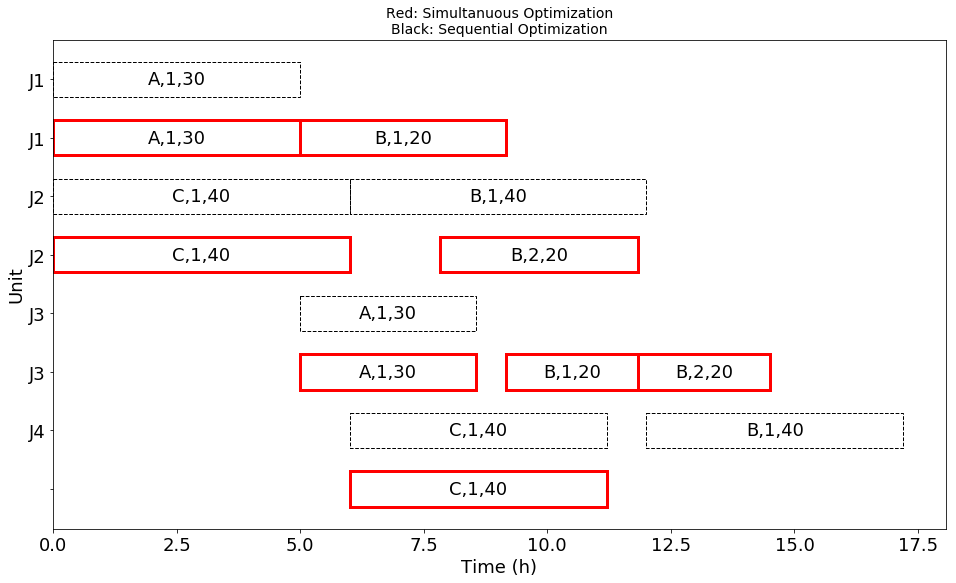

In [33]:
model.B['A',1].fixed=False
model.B['B',1].fixed=False
model.B['C',1].fixed=False

opt.solve(model,tee=False)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for k in model.K:
    for i,l,j in model.X:
        if (j,k) in model.Jk and model.X[i,l,j] != 0:
            rect = ax.barh(model.J.ord(j), (model.tau_F[i,j]+model.tau_P[i,j]*model.B_[i,l,j].value), 0.3, left=model.T[i,l,k].value - (model.tau_F[i,j]+model.tau_P[i,j]*model.B_[i,l,j].value), align='center', color='None',linestyle='-', edgecolor='Red',linewidth = 3)
            xloc = rect[0].get_x() + rect[-1].get_width()/2.0; yloc = rect[-1].get_y() + rect[-1].get_height()/2.0
            ax.text(xloc, yloc, '{},{},{:.0f}'.format(i,l,model.B_[i,l,j].value), horizontalalignment='center',verticalalignment='center', color='Black',clip_on=True,fontsize=18)

model.B['A',1].fix(30)
model.B['B',1].fix(40)
model.B['C',1].fix(40)
opt.solve(model,tee=False);

for k in model.K:
    for i,l,j in model.X:
        if (j,k) in model.Jk and model.X[i,l,j] != 0:
            rect = ax.barh(model.J.ord(j)-0.5, (model.tau_F[i,j]+model.tau_P[i,j]*model.B_[i,l,j].value), 0.3, left=model.T[i,l,k].value - (model.tau_F[i,j]+model.tau_P[i,j]*model.B_[i,l,j].value), align='center', color='None',linestyle='--', edgecolor='Black',linewidth = 1)
            xloc = rect[0].get_x() + rect[-1].get_width()/2.0; yloc = rect[-1].get_y() + rect[-1].get_height()/2.0
            ax.text(xloc, yloc, '{},{},{:.0f}'.format(i,l,model.B_[i,l,j].value), horizontalalignment='center',verticalalignment='center', color='Black',clip_on=True,fontsize=18)

            
            
            
ax.invert_yaxis()
ax.set_yticklabels([1,'J1','J1','J2','J2','J3','J3','J4'],fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel('Unit',fontsize=18)
plt.xlabel('Time (h)',fontsize=18)
plt.title('Red: Simultanuous Optimization\nBlack: Sequential Optimization',fontsize=14)
plt.show()